# Métodos numéricos para solução de equações não lineares

Escrevemos em XXX o resumo dos algoritmos de alguns métodos para solução de equações não lineares, e não são os únicos. Modificações desses métodos, em especial do Método de Newton são constantemente sugeridas para melhorar a
convergência. Fica claro que muitos sistemas no mundo real são não lineares. Uma aplicação comum é resolver problemas de otimização. Por exemplo, quando queremos maximizar em conjuntos abertos, se conseguirmos provar algumas condições, podemos assegurar que o máximo se encontra quando $f'(x) = 0$. Logo, o problema de otimização se resume a um problema de encontrar raízes. 

In [1]:
import numpy as np
import scipy.special as scis
import scipy.optimize as scop
import matplotlib.pyplot as plt

%matplotlib inline

Um jogador A ganha com placar (21-0) do jogador B em um jogo de [raquetebol](https://pt.wikipedia.org/wiki/Raquetebol) com [probabilidade](https://dokumen.tips/documents/probability-of-a-shutout-in-racquetball-58dea76bc2677.html). 

$$
P = \frac{p+1}{2}\left(\frac{p}{1-p+p^2}\right)^{21},
$$

em que $p$ é a probabilidade de $A$ ganhar um rally qualquer. Qual o valor de $p$ que assegura que $A$ vencerá com esse placar em pelo menos metade dos jogos? Esse é um problema real proposto por Ralph Levine para Joseph Keller.

In [2]:
def P(p):
    return (p+1)/2 * (p/(1 + p**2-p))**(21)

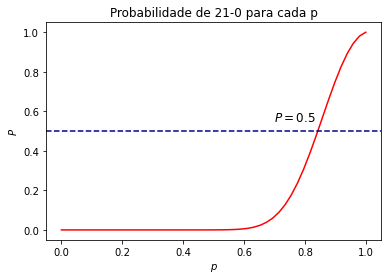

In [3]:
p_values = np.linspace(0, 1, 50)
P_values = P(p_values)
plt.plot(p_values, P_values, color='r')
plt.axhline(0.5, linestyle = '--', color = 'darkblue')
plt.title('Probabilidade de 21-0 para cada p')
plt.text(0.7, 0.55, '$P = 0.5$', fontsize=12)
plt.xlabel('$p$')
plt.ylabel('$P$')
plt.show()

Vamos explorar métodos de resolver a equação $P(p) = 0.5$ para $p$, isto é, $P(p) - 0.5 = 0$, através do método do Ponto Fixo e do Método de Newton.  

## Iteração de Ponto Fixo

Temos que 

$$
f(p) = 0.5 - \frac{p+1}{2}\left(\frac{p}{1-p+p^2}\right)^{21} + p = p,
$$

é a função que admite o ponto fixo que queremos. Um ponto importante seria provar as condições de funcionamento do método. Porém, não é difícil ver que $f([0,1]) \not \subseteq [0,1]$, o que já quebra nosso teorema.

In [4]:
def f(p): 
    return 0.5 - P(p) + p

def fixed_point(x0, tol = 1e-5, max_ite = 1e4): 
    
    x1 = f(x0)
    err = [abs(x1 - x0)]
    sols = [x0, x1]
    
    while err[-1] > tol and len(err) <= max_ite: 
        
        sols.append(f(sols[-1]))
        err.append(abs(sols[-1] - sols[-2]))
        
    return {'sol': sols, 'errors': err}

print(f(0.7))

1.1329638832103943


Bom, mas vamos supor que mesmo assim quiséssemos usar esse método.

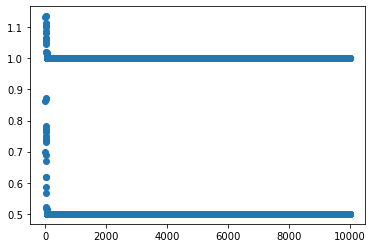

In [5]:
res = fixed_point(0.7)
plt.scatter(range(len(res['sol'])), res['sol'])

Ele não converge! Mas a gente já devia ter ficado desconfiado, pois justamente as condições do Teorema não functionavam. Em particular, é fácil ver que ele não é nem não expansivo. Usando Scipy:

In [6]:
scop.fixed_point(func = f, x0 = 0.81, method = 'iteration')

RuntimeError: Failed to converge after 500 iterations, value is 0.4998542288112865

Existe uma variação desse dado pelo método Steffensen com Aitken's $\Delta^2$, que constrói uma sequência com onvergência mais rápida, a partir da inicial. 

In [7]:
%timeit scop.fixed_point(func = f, x0 = 0.3, method = 'del2')

747 µs ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
scop.fixed_point(func = f, x0 = 0.3, method = 'del2')

array(0.84230479)

In [9]:
%timeit scop.fixed_point(func = f, x0 = 0.8, method = 'del2')

650 µs ± 31.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
scop.fixed_point(func = f, x0 = 0.8, method = 'del2')

array(0.84230479)

Olhe o que acontece com $x_0 = 0.1$. 

In [11]:
scop.fixed_point(func = f, x0 = 0.1, method = 'del2')

array(-3.51843721e+13)

## Método de Newton 

Agora vamos usar informação da derivada de $P$ para nos ajudar com o problema de encontrar a raíz de $P(p) - 0.5 = 0$. Note que $P(0) < 0.5$ e $P(1) > 0.5$. }Para nos ajudar com as contas, vamos considerar a versão com log, isto é, $\log(P(p)) = - \log(2)$. Assim, 

$$ 
\log(p+1) - \log(2) + 21(\log(p) - \log(1 - p + p^2)) = -\log(2), 
$$

o que simplica para $g(p) = \log(p+1) + 21(\log(p) - \log(1 - p + p^2)) = 0$. Aí temos que 

$$
g'(p) = \frac{1}{p+1} + \frac{21}{p} - \frac{21}{1 - p + p^2}(2p - 1)
$$

In [12]:
def g(p): 
    return np.log(p+1) + 21*(np.log(p) - np.log1p(p**2 - p))

def g_prime(p): 
    return 1 / (p+1) + 21 / p - 21 * (2*p - 1) / (1 - p + p**2)

Podemos provar analiticamente que a derivada é estritamente positiva, mas faremos a observação numérica através do seguinte gráfico. 

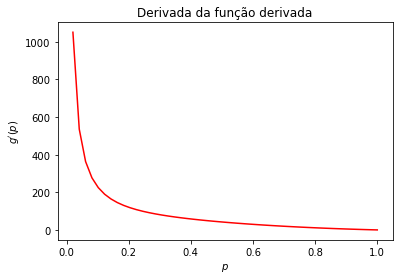

In [13]:
g_values = g_prime(p_values[1:])
plt.plot(p_values[1:], g_values, color='r')
plt.title('Derivada da função derivada')
plt.xlabel('$p$')
plt.ylabel("$g\'(p)$")
plt.show()

Aplicando o método de newton através do Scipy. Observe que o seu tempo deu bem menor que o anterior, mesmo com um valor de $x_0$ bem distante. 

In [14]:
%timeit scop.newton(func = g, x0 = 0.1, fprime = g_prime)

368 µs ± 24.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
scop.newton(func = g, x0 = 0.1, fprime = g_prime)

0.8423047910355657

Observe o método da Secante, um método que também usa a ideia de tangente, mas sem consultar a derivada. 

In [16]:
%timeit scop.newton(func = g, x0 = 0.1)

459 µs ± 31.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
scop.newton(func = g, x0 = 0.1)

0.8423047910355633

### Exemplo adicional 

Nesse exemplo, a ideia é verificar que Newton pode dar errado. Considere: 

$$
f(x) = x\sin(\pi x) - \exp(-x)
$$

In [18]:
f = lambda x: x * np.sin(np.pi * x) - np.exp(-x)

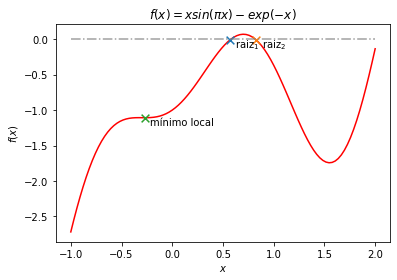

In [19]:
x = np.linspace(-1, 2, 100)
y = f(x)

fig, ax = plt.subplots()
ax.plot(x, y, color='r',zorder=0)
xs = [0.57, 0.83, -0.27]
texts = ['raiz$_1$', 'raiz$_2$', 'mínimo local']
for i in range(len(xs)):
    ax.scatter([xs[i]], [f(xs[i])],marker='x',s=60)
    ax.text(xs[i]+0.05, f(xs[i])-0.1, texts[i])
ax.plot(x,np.zeros_like(x),color='gray',ls='-.',alpha=0.75)
ax.set_xlabel('$x$')
ax.set_ylabel('$f(x)$')
plt.title('$f(x)= x sin(\pi x) - exp(-x)$')
plt.show()

In [20]:
xspace = np.linspace(-0.7, 0.7, 15)

for x in xspace:
    print('Com x_0 = {0:5.2f}, a raíz é {1:5.2f}'.format(x, scop.newton(f,x)))

Com x_0 = -0.70, a raíz é  2.02
Com x_0 = -0.60, a raíz é  0.58
Com x_0 = -0.50, a raíz é  1.27
Com x_0 = -0.40, a raíz é  0.82
Com x_0 = -0.30, a raíz é -0.30
Com x_0 = -0.20, a raíz é  0.82
Com x_0 = -0.10, a raíz é  2.02
Com x_0 =  0.00, a raíz é  0.82
Com x_0 =  0.10, a raíz é  0.58
Com x_0 =  0.20, a raíz é  0.58
Com x_0 =  0.30, a raíz é  0.58
Com x_0 =  0.40, a raíz é  0.58
Com x_0 =  0.50, a raíz é  0.58
Com x_0 =  0.60, a raíz é  0.58
Com x_0 =  0.70, a raíz é  0.58
